In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch
!pip install -U keras-tuner
import kerastuner as kt

2023-08-18 13:26:43.296197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 13:26:43.428460: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-18 13:26:43.434171: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-

In [2]:
menu_board = pd.read_csv('menu_category.csv')
menu_board

,day,morning,lunch,dinner
0,1,4,4,4
1,2,4,4,4
2,3,4,4,4
3,4,7,7,7
4,5,7,7,7
...,...,...,...,...
175,176,10,12,10
176,177,10,12,10
177,178,12,12,12
178,179,12,12,12


In [3]:
data = []
for k in range(0,180):
    haru = menu_board.iloc[k,1:].tolist()
    data.extend([number for number in haru])
data = pd.DataFrame(data)
data

,0
0,4
1,4
2,4
3,4
4,4
...,...
535,12
536,12
537,12
538,12


In [4]:
x = []
for k in range(0,540-21):
    row = [data.iloc[k+i,0] for i in range(21)]
    x.append(row)
    
y = data.iloc[21:]

x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [5]:
len(x)

519

In [6]:
len(y)

519

In [7]:
data.iloc[21:]

,0
21,2
22,2
23,2
24,2
25,2
...,...
535,12
536,12
537,12
538,12


In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y)

In [9]:
x_train = tf.reshape(x_train,(-1,21,1))
x_test = tf.reshape(x_test,(-1,21,1))

2023-08-18 13:26:49.831458: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-08-18 13:26:49.831586: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-08-18 13:26:49.831651: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras

In [10]:
x_train.shape

TensorShape([389, 21, 1])

In [11]:
nb_classes = 13
y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_classes)
y_train = tf.reshape(y_train,[-1,nb_classes])
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_classes)
y_test = tf.reshape(y_test,[-1,nb_classes])

In [12]:
y_train.shape

TensorShape([389, 13])

In [13]:
from keras.optimizers import Adadelta
from keras.layers import Dropout
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=21, output_dim=50, input_length=21))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=True, input_shape=[21,1]))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(13,activation='softmax'))

learning_rate = 0.1
optimizer = Adadelta(learning_rate=1.0, rho=0.95)
#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#metrics = tf.keras.metrics.SparseCategorica.Accuracy()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(x_train, y_train, epochs=100, verbose=0)

In [15]:
model.predict(x_test)

5/5 [==============================] - 1s 8ms/step


array([[3.1585427e-04, 2.5753937e-07, 5.1274657e-07, ..., 2.1368598e-03,
        9.0780616e-01, 8.8216206e-03],
       [6.6411354e-07, 2.6944986e-01, 7.3028684e-01, ..., 1.3306163e-08,
        1.3057811e-08, 6.4620140e-09],
       [1.7952677e-02, 9.2031195e-07, 7.6397226e-09, ..., 5.5415523e-01,
        4.2185959e-01, 1.4306272e-04],
       ...,
       [9.9932100e-04, 3.6002029e-07, 1.4004178e-07, ..., 2.5986066e-01,
        1.0306959e-03, 6.5588939e-01],
       [7.8796912e-03, 2.3740580e-07, 2.4166695e-09, ..., 1.8080357e-01,
        8.0785787e-01, 6.5230000e-05],
       [9.0219826e-03, 8.5232923e-06, 2.0144005e-06, ..., 6.8864781e-01,
        1.1630417e-02, 2.0586015e-01]], dtype=float32)

In [16]:
y_test

<tf.Tensor: shape=(130, 13), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)>

In [17]:
model.evaluate(x_test,y_test)

5/5 [==============================] - 1s 8ms/step - loss: 1.5847 - accuracy: 0.5308


[1.5846821069717407, 0.5307692289352417]

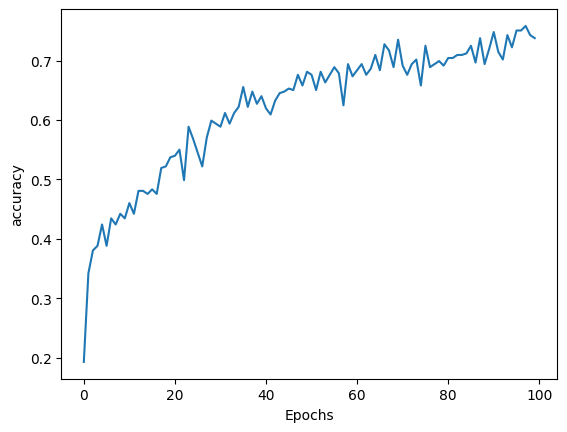

In [18]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
    
plot_graphs(history, 'accuracy')

In [19]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [21]:
import graphviz

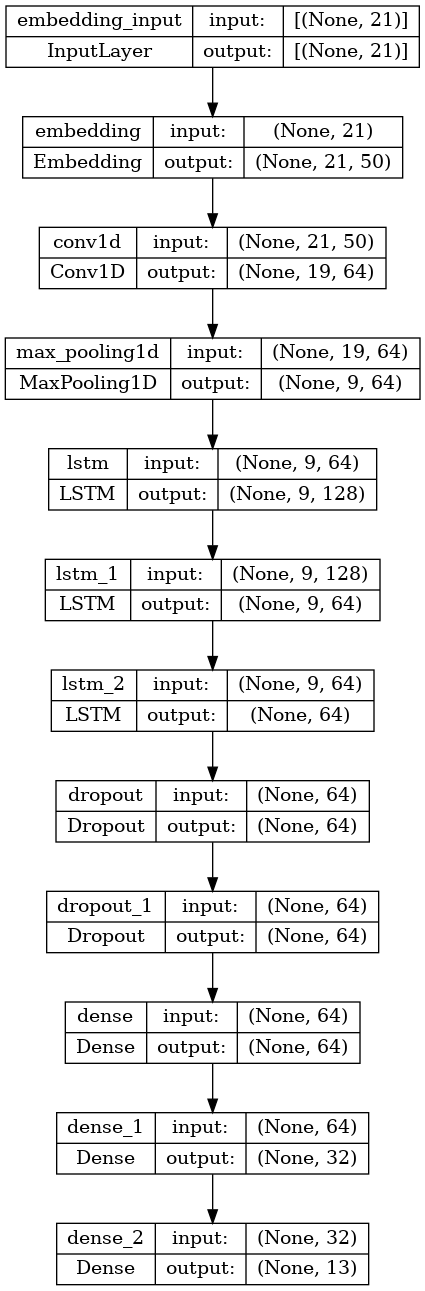

In [22]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

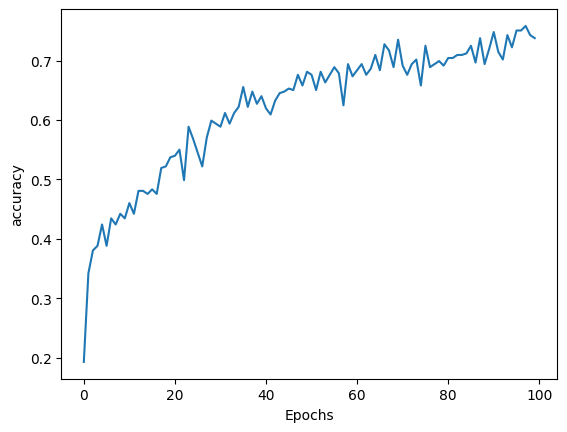

In [23]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
    
plot_graphs(history, 'accuracy')